In [1]:
import xml.etree.ElementTree as ElementTree
import tensorflow as tf
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class Element:
    def __init__(self, number, name, element, mass):
        self.number = int(number)
        self.name = name
        self.element = element
        self.mass = float(mass)
        
    def __repr__(self):
        return f'{self.element}-Element(id={self.number}, name={self.name}, mass={self.mass})'
    
class Bond:
    def __init__(self, id_from, id_to):
        self.id_from = int(id_from)
        self.id_to = int(id_to)
        
    def __repr__(self):
        return f'Bond(from={self.id_from}, to={self.id_to})'
    
class Residue:
    def __init__(self, name, atoms, bonds):
        self.name = name
        self.atoms = atoms
        self.bonds = bonds
        
    def __repr__(self):
        return f'{self.name}-Residue(n_atoms={len(self.atoms)}, n_bonds={len(self.bonds)})'

In [3]:
class Elements:
    def __init__(self, tree):
        self.tree = tree
        
    def __getitem__(self, index):
        if type(index) == int:
            return self.tree[index]
        elif type(index) == tuple and len(index) == 2:
            if type(index[0]) == int and type(index[1]) == str:
                return self.tree[index[0]].attrib[index[1]]
            
        print(f'Index {(type(i) for i in index)} not supported')
        return None

    def __repr__(self):
        return f'Elements(count={len(self.tree)})'
    
class Residues:
    def __init__(self, tree):
        self.tree = tree
        
    def __getitem__(self, index):
        if type(index) == int:
            return self.tree[index]
        elif type(index) == tuple:
            curr = self.tree
            for i in index:
                if type(i) == int:
                    curr = curr[i]
                elif type(i) == str:
                    curr = curr.attrib[i]
                else:
                    print(f'Index {(type(i) for i in index)} not supported')
                    return None
            return curr
        print(f'Index {(type(i) for i in index)} not supported')
        return None

    def __repr__(self):
        return f'Residues(count={len(self.tree)})'
    
class HarmonicBondForces:
    def __init__(self, tree):
        self.tree = tree
        
    def get_force_between(self, e1, e2):
        for bond in self.tree:
            if bond.attrib['class1'] == e1.name and bond.attrib['class2'] == e2.name:
                return bond
            elif bond.attrib['class1'] == e2.name and bond.attrib['class2'] == e1.name:
                return bond
        
    def __getitem__(self, index):
        if type(index) == int:
            return self.tree[index]
        elif type(index) == tuple:
            curr = self.tree
            for i in index:
                if type(i) == int:
                    curr = curr[i]
                elif type(i) == str:
                    curr = curr.attrib[i]
                else:
                    print(f'Index {(type(i) for i in index)} not supported')
                    return None
            return curr
        print(f'Index {(type(i) for i in index)} not supported')
        return None

    def __repr__(self):
        return f'HarmonicBondForces(count={len(self.tree)})'

In [4]:
tree = ElementTree.parse('forcefields/amber99sb.xml').getroot()

elements_tree = tree[0]
elements = []
for elem in elements_tree:
    elements.append(Element(elem.attrib['name'], elem.attrib['class'], elem.attrib['element'], elem.attrib['mass']))
    
residues_tree = tree[1]
residues = []
for res in residues_tree:
    atoms = []
    bonds = []
    for obj in res:
        if obj.tag == 'Atom':
            atoms.append(elements[int(obj.attrib['type'])])
        elif obj.tag == 'Bond':
            bonds.append(Bond(obj.attrib['from'], obj.attrib['to']))
    residues.append(Residue(res.attrib['name'], atoms, bonds))

In [5]:
e = Elements(tree[0])
r = Residues(tree[1])
f = HarmonicBondForces(tree[2])

In [6]:
class Atom:
    def __init__(self, name):
        self.name = name
        self.pos = tf.Variable(tf.random.uniform(shape=(3,)))

class HarmonicBondForce:
    def __init__(self, a1, a2, dist, k):
        self.atom1 = a1
        self.atom2 = a2
        self.dist = float(dist)
        self.k = 1 # should be float(k) but high k values currently lead to NaN energy values
    
    @tf.function
    def __call__(self):
        return self.k * (tf.norm(self.atom2.pos - self.atom1.pos) - self.dist) ** 2

In [7]:
test = [res for res in residues if res.name == 'PRO'][0]

atoms = []
for a in test.atoms:
    atoms.append(Atom(a.name))

forces = []
for b in test.bonds:
    elem_from = test.atoms[b.id_from]
    elem_to = test.atoms[b.id_to]
    bond = f.get_force_between(elem_from, elem_to)
    atom_from = atoms[b.id_from]
    atom_to = atoms[b.id_to]
    forces.append(HarmonicBondForce(atom_from, atom_to, bond.attrib['length'], bond.attrib['k']))

In [8]:
steps = 100
for step in range(steps):
    with tf.GradientTape() as tape:
        energy = tf.reduce_sum([force() for force in forces])
        gradient = tape.gradient(energy, [atom.pos for atom in atoms])
        
    for grad, atom in zip(gradient, atoms):
        atom.pos.assign_sub(0.1 * grad)
        
    if step % (steps // 10) == 0:
        print(energy)

tf.Tensor(5.625772, shape=(), dtype=float32)
tf.Tensor(0.016555805, shape=(), dtype=float32)
tf.Tensor(0.0009920029, shape=(), dtype=float32)
tf.Tensor(0.00013438186, shape=(), dtype=float32)
tf.Tensor(2.3514032e-05, shape=(), dtype=float32)
tf.Tensor(4.5289125e-06, shape=(), dtype=float32)
tf.Tensor(9.1012635e-07, shape=(), dtype=float32)
tf.Tensor(1.8633564e-07, shape=(), dtype=float32)
tf.Tensor(3.845078e-08, shape=(), dtype=float32)
tf.Tensor(7.968971e-09, shape=(), dtype=float32)


<IPython.core.display.Javascript object>


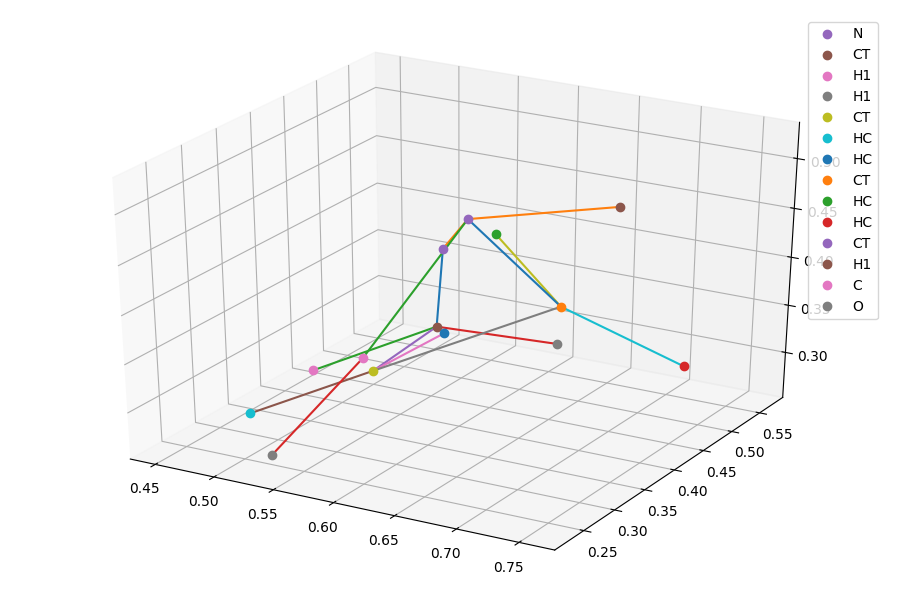

In [9]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

for bond in test.bonds:
    p1 = atoms[bond.id_from].pos.numpy()
    p2 = atoms[bond.id_to].pos.numpy()
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]])

for atom in atoms:
    pos = atom.pos.numpy()
    ax.plot([pos[0]], [pos[1]], [pos[2]], 'o', label=atom.name)
    
plt.legend()
plt.tight_layout()
plt.show()